# Early Access

The goal of this program is to determine the likelihood of Early Access Games to leave Early Access.

---

# Zeb's badical checklist

- [X] predictive  model
- [X] 300 words 
- [ ] Visuals. What you have done or plan to do
- [ ] interactive dash or sturdy blog post
- [ ] If doing dash, have you deployed successfully on Heroku

## Data Viewing and Cleaning

In [1]:
# The goal of this program is to determine the likelihood of Early Access Games to
# leave Early Access.

import pandas as pd
import pandas_profiling


def google_drive_useable(link):
    return link.replace('/open?', '/uc?')

data = r'https://drive.google.com/open?id=1pEOgqOZcgxwu7gA4GnFuMwO_wVBLQ7cf'
df   = pd.read_csv(google_drive_useable(data))

In [24]:
# df.to_csv(r'Steam Game Data Cleaned.csv', index = False, header = True)

In [ ]:
df.profile_report(style = {'full_width': True})

## Train, Val, Test Split

In [2]:
# Split the data
from sklearn.model_selection import train_test_split

target      = 'ReleaseType'
filtered_df = df[df[target] != 'Traditional Release']

train, test = train_test_split(filtered_df
                              ,train_size   = 0.60
                              ,random_state = 6
                              )

train, val  = train_test_split(train
                              ,train_size   = 0.60
                              ,random_state = 6
                              )

### Baseline

In [3]:
# Baseline Guess is everything stays in Early Access

baseline_guess  = 'Early Access'
baseline_y_pred = [baseline_guess] * len(filtered_df)

filtered_df[target].value_counts(normalize = True)

Early Access       0.686476
Ex Early Access    0.313524
Name: ReleaseType, dtype: float64

In [4]:
target   = 'ReleaseType'
features = ['Metacritic'
           ,'YearsSinceRelease'
           ,'ReleaseDate'
           
           ,'RecommendationCount'
           ,'DeveloperCount'
           ,'PublisherCount'
           ,'DLCCount'
           ,'ScreenshotCount'
           
           ,'CategorySinglePlayer'
           ,'CategoryMultiplayer'
           ,'CategoryCoop'
           ,'CategoryMMO'
           ,'CategoryInAppPurchase'
           ,'CategoryIncludeSrcSDK'
           ,'CategoryIncludeLevelEditor'
           ,'CategoryVRSupport'
           
           ,'GenreIsIndie'
           ,'GenreIsAction'
           ,'GenreIsAdventure'
           ,'GenreIsCasual'
           ,'GenreIsStrategy'
           ,'GenreIsRPG'
           ,'GenreIsSimulation'
           ,'GenreIsSports'
           ,'GenreIsRacing'
           ,'GenreIsMassivelyMultiplayer'
           
           ,'PlatformWindows'
           ,'PlatformLinux'
           ,'PlatformMac'
           
           ,'PriceInitial'
           ,'PriceFinal'
           ]

In [5]:
X_train  = train[features]
y_train  = train[target]

X_val    =  val[features]
y_val    =  val[target]

X_test   =  test[features]
y_test   =  test[target]

train.shape, test.shape

((769, 47), (855, 47))

## 2 Models

### Random Forest Classifier

Model 1

In [6]:
import numpy             as np
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.impute   import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics  import accuracy_score, precision_score, recall_score


rf_pipe = make_pipeline(ce.OrdinalEncoder()
                       ,SimpleImputer()
                       ,RandomForestClassifier(n_estimators = 200)
                       )
rf_pipe.fit(X_train, y_train)

y_train_pred = rf_pipe.predict(X_train)
y_val_pred   = rf_pipe.predict(X_val)

y_train_prob = rf_pipe.predict_proba(X_train)[:,1]
y_val_prob   = rf_pipe.predict_proba(X_val)[:,1]

In [7]:
# A way to get my metrics all in one place.

def cat_prediction_results(y_train
                          ,y_val
                          ,y_train_pred
                          ,y_val_pred
                          ,cat_target    = y_train.unique()[0]
                          ,sort_by       = 'prediction'
                                                              ):
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score

    
    metrics     = {accuracy_score:  'Accuracy'
                  ,precision_score: 'Precision'
                  ,recall_score:    'Recall'
                  }
    
    base_y_pred = [cat_target] * len(y_train)
    
    predictions = [['Baseline',   y_train,  base_y_pred]
                  ,['Training',   y_train, y_train_pred]
                  ,['Validation', y_val,     y_val_pred]
                  ]
    
    if sort_by.lower() == 'prediction' or 'predictions':
        for prediction in predictions:
            for metric in metrics:
                if metrics[metric] == 'Accuracy':
                    print(prediction[0],  str(metrics[metric]) + ':\t', metric(prediction[1], prediction[2]))
                else:
                    print(prediction[0],  str(metrics[metric]) + ':\t', metric(prediction[1], prediction[2], pos_label = cat_target))
            print()
    else:
        for metric in metrics:
            if metrics[metric] == 'Accuracy':
                print("Baseline",   metrics[metric], ':\t', metric(y_train, baseline_y_pred))
                print("Training",   metrics[metric], ':\t', metric(y_train,    train_y_pred))
                print("Validation", metrics[metric], ':\t', metric(y_val,        val_y_pred))
            else:
                print("Baseline",   metrics[metric], ':\t', metric(y_train, baseline_y_pred, pos_label = cat_target))
                print("Training",   metrics[metric], ':\t', metric(y_train,    train_y_pred, pos_label = cat_target))
                print("Validation", metrics[metric], ':\t', metric(y_val,        val_y_pred, pos_label = cat_target))
            print()


In [8]:
search = cat_prediction_results(y_train
                               ,y_val
                               ,y_train_pred
                               ,y_val_pred
                               ,cat_target = 'Ex Early Access'
                               ,sort_by    = 'predictions'
                               )
search

Baseline Accuracy:	 0.3107932379713914
Baseline Precision:	 0.3107932379713914
Baseline Recall:	 1.0

Training Accuracy:	 1.0
Training Precision:	 1.0
Training Recall:	 1.0

Validation Accuracy:	 0.9512670565302144
Validation Precision:	 0.9627329192546584
Validation Recall:	 0.8908045977011494



### Logistic Regression

Model 2

In [23]:
import numpy             as np
import category_encoders as ce
from sklearn.pipeline     import make_pipeline
from sklearn.impute       import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics      import accuracy_score, precision_score, recall_score


lr_pipe = make_pipeline(ce.OrdinalEncoder()
                       ,SimpleImputer()
                       ,LogisticRegression(solver     = 'liblinear'
                                          )
                       )
lr_pipe.fit(X_train, y_train)

y_train_pred = lr_pipe.predict(X_train)
y_val_pred   = lr_pipe.predict(X_val)

y_train_prob = lr_pipe.predict_proba(X_train)[:,1]
y_val_prob   = lr_pipe.predict_proba(X_val)[:,1]

In [24]:
search = cat_prediction_results(y_train
                               ,y_val
                               ,y_train_pred
                               ,y_val_pred
                               ,cat_target = 'Ex Early Access'
                               ,sort_by    = 'predictions'
                               )
search

Baseline Accuracy:	 0.3107932379713914
Baseline Precision:	 0.3107932379713914
Baseline Recall:	 1.0

Training Accuracy:	 0.9258777633289987
Training Precision:	 0.955
Training Recall:	 0.799163179916318

Validation Accuracy:	 0.9025341130604289
Validation Precision:	 0.9305555555555556
Validation Recall:	 0.7701149425287356



## Visualizations

---

### Shap Plot

An explainer which hooks into the model

In [15]:
def force_explain(X_train, y_train, X_val, y_val, row):
    import category_encoders as ce
    from sklearn.pipeline import make_pipeline
    from sklearn.impute   import SimpleImputer
    from xgboost          import XGBClassifier
    
    import shap
    
    
    # Pipeline to process the dataframe for use
    shap_pipe         = make_pipeline(ce.OrdinalEncoder()
                                     ,SimpleImputer(strategy = 'median')
                                     )

    X_train_processed = shap_pipe.fit_transform(X_train)
    X_val_processed   = shap_pipe.transform(X_val)

    # Set the model
    shap_model        = XGBClassifier(n_estimators = 1000
                                     ,n_jobs       = -1
                                     )

    # Take in processed data 
    shap_model.fit(X_train_processed
                  ,y_train
                  ,eval_set              = [(X_val_processed, y_val)]
                  ,eval_metric           = 'auc'
                  ,early_stopping_rounds = 10
                  ,verbose               = False
                  )

    explainer     = shap.TreeExplainer(shap_model)
    
    selected_row  = X_train.iloc[[row]]
    row_processed = shap_pipe.transform(selected_row)
    
    shap.initjs()
    return shap.force_plot(base_value  = explainer.expected_value
                          ,shap_values = explainer.shap_values(row_processed)
                          ,features    = selected_row
                          ,link        = 'logit'
                          )

In [16]:
force_explain(X_train
             ,y_train
             ,X_val
             ,y_val
             ,row = 415
             )

### PDP Isolate

Shows how one variable can affect the outcome.

In [80]:
def pdp_isolate_explain(X, y, feature):
    import category_encoders as ce
    from sklearn.pipeline import make_pipeline
    from sklearn.impute   import SimpleImputer
    from sklearn.ensemble import RandomForestClassifier
    from pdpbox.pdp       import pdp_isolate, pdp_plot

    
    # Encode, impute as needed
    X_encoded   = ce.OrdinalEncoder().fit_transform(X)
    X_processed = SimpleImputer().fit_transform(X_encoded)

    # Pick a model and fit the data
    pdp_model = RandomForestClassifier(n_estimators = 200
                                      ,n_jobs       = -1
                                      ,random_state = 6
                                      )
    pdp_model.fit(X_processed
                 ,y
                 )

    # The actual plotting
    pdp_isolate = pdp_isolate(model          = pdp_model
                             ,dataset        = X_encoded
                             ,model_features = X_encoded.columns
                             ,feature        = feature
                             )
    pdp_plot(pdp_isolate
            ,feature_name = feature
            ,plot_lines   = True
            ,frac_to_plot = 100
            )

In [73]:
X_train.columns

Index(['Metacritic', 'YearsSinceRelease', 'ReleaseDate', 'RecommendationCount',
       'DeveloperCount', 'PublisherCount', 'DLCCount', 'ScreenshotCount',
       'CategorySinglePlayer', 'CategoryMultiplayer', 'CategoryCoop',
       'CategoryMMO', 'CategoryInAppPurchase', 'CategoryIncludeSrcSDK',
       'CategoryIncludeLevelEditor', 'CategoryVRSupport', 'GenreIsIndie',
       'GenreIsAction', 'GenreIsAdventure', 'GenreIsCasual', 'GenreIsStrategy',
       'GenreIsRPG', 'GenreIsSimulation', 'GenreIsSports', 'GenreIsRacing',
       'GenreIsMassivelyMultiplayer', 'PlatformWindows', 'PlatformLinux',
       'PlatformMac', 'PriceInitial', 'PriceFinal'],
      dtype='object')

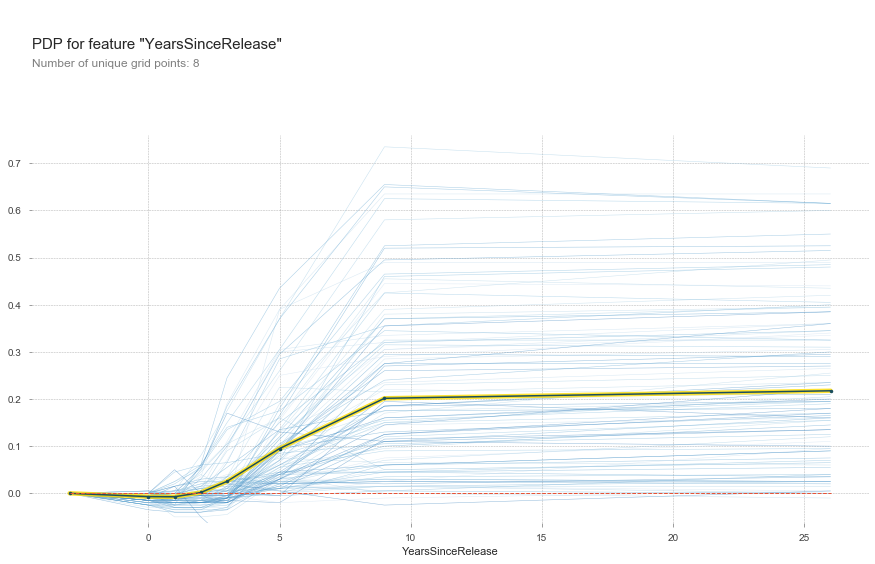

In [81]:
feature = 'YearsSinceRelease'
pdp_isolate_explain(X_train
                   ,y_train
                   ,feature
                   )

### PDP Interact

In [84]:
def pdp_interact_explain(X, y, feature):
    import category_encoders as ce
    from sklearn.pipeline import make_pipeline
    from sklearn.impute   import SimpleImputer
    from sklearn.ensemble import RandomForestClassifier
    from pdpbox.pdp       import pdp_interact, pdp_interact_plot

    
    # Encode, impute as needed
    X_encoded   = ce.OrdinalEncoder().fit_transform(X)
    X_processed = SimpleImputer().fit_transform(X_encoded)

    # Pick a model and fit the data
    pdp_model = RandomForestClassifier(n_estimators = 200
                                      ,n_jobs       = -1
                                      ,random_state = 6
                                      )
    pdp_model.fit(X_processed
                 ,y
                 )

    # The actual plotting
    pdp_interact = pdp_interact(model          = pdp_model
                               ,dataset        = X_encoded
                               ,model_features = X_encoded.columns
                               ,features       = feature
                               )
    pdp_interact_plot(pdp_interact
                     ,feature_names = feature
                     ,plot_type     = 'grid'
                     )

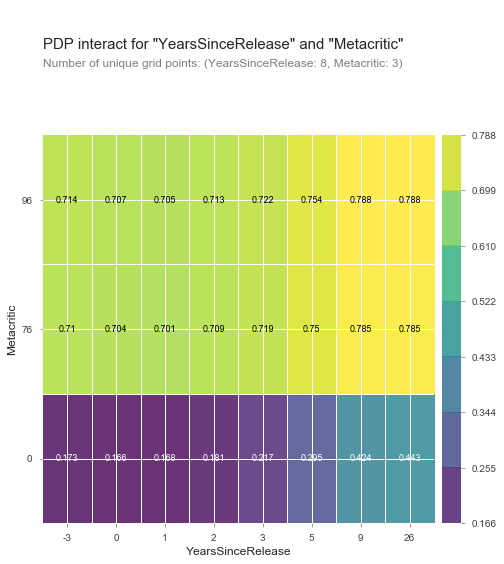

In [85]:
feature = ['YearsSinceRelease', 'Metacritic']
pdp_interact_explain(X_train
                    ,y_train
                    ,feature
                    )

### Dash

In [ ]:
# Dash.py

import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd


# My dataframe is on google drive, so this changes a google drive link
# into something usable
def google_drive_useable(link):
    return link.replace('/open?', '/uc?')

data = r'https://drive.google.com/open?id=1pEOgqOZcgxwu7gA4GnFuMwO_wVBLQ7cf'
df   = pd.read_csv(google_drive_useable(data))


# This creates a dataframe table to view on the web page
def generate_table(dataframe, max_rows = 10):
    return html.Table(
        # Header
        [html.Tr([html.Th(col) for col in dataframe.columns])] +

        # Body
        [html.Tr([
            html.Td(dataframe.iloc[i][col]) for col in dataframe.columns
        ]) for i in range(min(len(dataframe), max_rows))]
    )


# Just Styling
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']


# Setting up the App
app = dash.Dash(__name__, external_stylesheets = external_stylesheets)

app.layout = html.Div(children = [
    html.H4(children = 'US Agriculture Exports (2011)'),
    generate_table(df)
])


# Running it
if __name__ == '__main__':
    app.run_server(debug = True)